# Arbres de décision en Python: cas de la régression

<table><tr>
<td> <img src="files/figures/DT_1.png" width="300px"/> </td>
<td> </td>
<td> </td>
<td> <img src="files/figures/DT_2.png" width="300px"/> </td>
</tr></table>

## Librairies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Loader les data

In [2]:
data = pd.read_csv("./data/airfoil_self_noise.csv", sep='\t')

In [3]:
data.head(5)

,x0,x1,x2,x3,x4,y
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


Nous allons prédire la variable `y` en fonction des variables `x0`, `x1`, `x2`, `x3`, `x4`.

## Arbre de décision dans un contexte de régression

La classe `DecisionNode` ci-dessous représente un **noeud** d'un **arbre de décision**, ou encore, un **arbre de décision** en soi. 

*En effet, en programmation, un objet "noeud" qui pointe vers ses fils est une structure de données suffisante pour représenter un arbre binaire.*

- Un **noeud interne** représente un *split* de la forme $x_m \leq s$ (où $x_m$ est la $m$-ième composante de $\mathbf{x}$).<br>
Chaque noeud interne donc est associé à un `feature_index` $m$ et un `threshold` $s$.<br>
Un noeud interne est également associé à `var_red`: la réduction de variance engendrée par son split.


- Une **feuille** représente un sous-ensemble des data $R_k$ (*région*, *cellule de partition*).<br>
Chaque feuille est donc associée une `value`: la target moyenne des data dans $R_m$<br> 

$$\hat{y}_{R_k} = \frac{1}{|R_k|} \sum_{\{i : \mathbf{x_i} \in R_k\}} y_i$$

In [4]:
class DecisionNode():
    """
    Implements a decision node, or quivalently, a decision tree.
    
    As usual, a binary tree is identified with a root node contaning as chidren
    a left subtree and a right subtree.
    
    Here, an *internal node* represents a split of the form "x_m <= s",
    where m is the `feature_index` and s the `thresold` of the split.
    
    A *leaf node* represents a subset of the data (region, box, partition cell).
    It is associated with a `value`: the average target for the data in this region.
    """
    
    def __init__(self, feature_index=None, threshold=None, 
                 left=None, right=None, var_red=None, value=None):
        """
        Constructor.
        
        Parameters
        ----------
        feature_index : int
            index i of variable x_m for the node split (x_m <= s).
        threshold : Union[int, float]
            threshold s for the node split (x_m <= s).
        left : Union[DecisionNode, None]
            Left child of the node
        right : Union[DecisionNode, None]
            Right child of the node
        var_red : float
            variance reduction induced by the node split (x_m <= s).
        value : Union[float, None]
            if the node is a leaf, then value of this leaf.
        """

        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.var_red = var_red

        # for leaf node
        self.value = value
        
        # children
        self.left = left
        self.right = right
        
        
    def print_tree(self, tab=0):
        """Prints the node (i.e., the tree)."""
        
        if self.left is None and self.right is None: # leaf
            
            print("\t"*(tab), f"{self.value:.2f}")
            
        else:                                        # internal node
            self.left.print_tree(tab+1)
            print("\t"*(tab), f"X_{self.feature_index} < {self.threshold:.2f}")
            self.right.print_tree(tab+1)

La classe ci-dessous `DecisionTreeRegressor` représente un **arbre de décision** dans un contexte de régression.

In [24]:
class DecisionTreeRegressor():
    """
    Implements a decision tree for regression.
    """
    
    def __init__(self, min_samples=2, max_depth=2):
        """
        Constructor.
        
        Parameters
        ----------
        min_samples : int
            Minimal number of data necessary to envision a split.
            Otherwise, the node is a leaf (subset of data).
        max_depth : int
            Maximal depth of the tree.
            When max_depth is reached, no further split is performed.
        """
        
        # the root will become the decision tree
        self.root = None
        
        # stopping conditions
        self.min_samples = min_samples
        self.max_depth = max_depth
        
    
    def split_data(self, dataset, split):
        """
        Splits dataset according to a given split of the form x_m <= s.
        
        Parameters
        ----------
        dataset : ndarray
            Dataset to be split
        split : tuple
            A split "x_m <= s" is represented by the tuple (m, s),
            where m is the feature_index and s the threshold.
        
        Returns
        -------
        dataset_left, dataset_right : tuple[ndarray, ndarray]
            dataset_left: data satisfying the condition x_m <= s.
            dataset_right: data satisfying the scondition x_m > s.
        """
        feature_index, threshold = split
        mask = dataset[:, feature_index] <= threshold
        dataset_left = dataset[mask, :]
        dataset_right = dataset[np.logical_not(mask), :]

        return dataset_left, dataset_right
    
    
    def variance_reduction(self, dataset, dataset_left, dataset_right):
        """
        Computes the variance reduction of the targets induced by a split.
        
        Suppose that a split of a dataset has induces the 2 datasets:
        dataset_left and dataset_right (cf. method split_data).
        This function computes the variance $var_1$ of the y's of dataset as well as
        the weighted variance $var_2$ of the y's of left_dataset and right_dataset.
        The variance reduction is then given by $var_1 - var_2$.
        
        Parameters
        ----------
        dataset : ndarray
            Dataset before split.
        dataset_left : ndarray
            First dataset induced by the split.
        dataset_right : ndarray
            Second dataset induced by the split.
        
        Returns
        -------
        var_reduction : float
            variance reduction induced by the split.
        """
        y = dataset[:, -1]
        y_l = dataset_left[:, -1]
        y_r = dataset_right[:, -1]

        w_l = len(y_l) / len(y)
        w_r = len(y_r) / len(y)

        var_reduction = np.var(y) - ( w_l * np.var(y_l) + w_r * np.var(y_r) )
        return var_reduction

    
    def best_split(self, dataset):
        """
        Computes the best split for a dataset.
        
        For all feature $m$ and and all possible value $s$ of that feature,
        split the dataset according to the condition "x_m <= s" (self.split_data(...)).
        The split "x_m <= s" generates two datatsets: dataset_left and dataset_right.
        Compute the variance reduction associated to the three datasets (self.variance_reduction).
        Select the split associated with the largest variance reduction.
        
        Parameters
        ----------
        dataset : ndarray
            Dataset before split.
        
        Returns
        -------
        best_split : dict
            dictionary to store the best split.
            The keys of the dictionare are: 
            "feature_index", "threshold", "dataset_left", "dataset_right", "var_red".
        """
        best_split = {}
        best_var_red = -float("inf")
        nb_feats = dataset.shape[1] -1
        for m in range(nb_feats):
            thresholds = dataset[:, m]
            thresholds = np.unique(thresholds)

            for s in thresholds:
                split = (m, s)
                data_l, data_r = self.split_data(dataset, split)
                if len(data_l) > 0 and len(data_r) > 0:
                    var_red = self.variance_reduction(dataset, data_l, data_r)
                    if var_red > best_var_red:
                        best_split = {
                            "feature_index": m,
                            "threshold": s,
                            "dataset_left": data_l,
                            "dataset_right": data_r,
                            "var_reduction": var_red
                        }
                        best_var_red = var_red
        return best_split
    
    
    def leaf_value(self, region):
        """
        Compute the mean of targets of a non-splitable region. 
        Teh region is associated to a leaf node of the decision tree.
        
        Parameters
        ----------
        region : ndarray
            Non-splitable dataset that corresponds to a region oof the partition.
        
        Returns
        -------
        mean : float
            Mean of targets for the data in the region.
        """
        Y = region[:, -1]
        mean = np.mean(Y)

        return mean
    
    
    def build_tree(self, dataset, depth=0):
        """
        Builds the decision tree recursively.
        
        Parameters
        ----------
        dataset : ndarray
            Initial dataset to be split by the decision tree.
        depth : int
            Depth of the decision tree that has been built so far.
        
        Returns
        -------
        DecisionNode : DecisionNode
            The decision tree that represent the best successive splits
            for to the dataset.
        """
        
        num_samples = np.shape(dataset)[0]
        if num_samples >= self.min_samples and depth <= self.max_depth:
            split = self.best_split(dataset)
            if split["var_reduction"] >= 0:
                subtree_left = self.build_tree(split["dataset_left"], depth + 1)
                subtree_right = self.build_tree(split["dataset_right"], depth + 1)
                return DecisionNode(split["feature_index"], split["threshold"],
                                    subtree_left, subtree_right, split["var_reduction"])
            return None
        else:
            value = self.leaf_value(dataset)
            return DecisionNode(value=value)
    
    
    def fit(self, X, Y):
        """
        Fits the decision tree on the features X and targets Y.
        
        Parameters
        ----------
        X : ndarray
            Feature columns of the dataset.
        Y : ndarray
            Target column of the dataset.
        """
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
        
    def predict_single_point(self, x, tree):
        """        
        Predict the target y_hat associated to a point x.
        
        Parameters
        ----------
        x : ndarray
            Point x = (x_1,...,x_M) whose target is to be predicted.
            
        Returns
        -------
        y_hat : float
            Target associated to x.
        """
        if tree.value is not None:
            return tree.value
        if x[tree.feature_index] <= tree.threshold:
            return self.predict_single_point(x, tree.left)
        else :
            return self.predict_single_point(x, tree.right)
        
    
    def predict(self, X):
        """
        Predict the targets associated to a set of points.
        
        Parameters
        ----------
        X : ndarray
            Tensor of points X (dim N x M) whose targets are to be predicted.
            
        Returns
        -------
        Y : ndarray
            Tensor of targets (dim N x 1) associated to X.
        """
        predictions = np.array([self.predict_single_point(x, self.root) for x in X])
        return predictions

### Exercice 1

Complétez la méthode `split_data(...)` qui, étant donné un dataset `dataset` et un split `split` de la forme $x_m \leq s$, retourne deux datasets qui correspondent aux lignes de `dataset` qui satisfont et ne satisfont pas la condition `split`, respectivement.

Testez votre méthode comme suit:
```
tree = DecisionTreeRegressor()
dataset = np.array(data)
split = (2, 0.1) # split x_2 <= 0.1
dataset_left, dataset_right = tree.split_data(dataset, split)
dataset_left.shape, dataset_right.shape
```

In [13]:
tree = DecisionTreeRegressor()
dataset = np.array(data)
split = (2, 0.1) # split x_2 <= 0.1
dataset_left, dataset_right = tree.split_data(dataset, split)
dataset_left.shape, dataset_right.shape

((515, 6), (988, 6))

### Exercice 2

Complétez la méthode `variance_reduction(...)` qui, étant donné trois datasets `dataset`, `dataset_left` et `dataset_right`, retourne la **réduction de variance** associée aux targets $y_i$ de `dataset`, `dataset_left` et `dataset_right`.

La **réduction de variance** est calculée comme suit:

\begin{eqnarray*}
var   & = & \mathrm{Var} \left\{ y_i : (\mathbf{x_i}, y_i) \in \mathrm{dataset} \right\} \\
&& \\
var_l & = & \frac{|\mathrm{dataset\_left}|}{|\mathrm{dataset}|} \cdot \mathrm{Var} \left\{ y_i : (\mathbf{x_i}, y_i) \in \mathrm{dataset\_left} \right\} \\
&& \\
var_r & = & \frac{|\mathrm{dataset\_right}|}{|\mathrm{dataset}|} \cdot \mathrm{Var} \left\{ y_i : (\mathbf{x_i}, y_i) \in \mathrm{dataset\_right} \right\} \\
&& \\
reduction & = & var - (var_l + var_r)
\end{eqnarray*}

où $|X|$ dénote le nombre d'éléments de l'ensemble $X$.

Tester votre méthode comme suit:
```
tree = DecisionTreeRegressor()
dataset = np.array(data)
split = (2, 0.1) # split x_2 <= 0.1
dataset_left, dataset_right = tree.split_data(dataset, split)
tree.variance_reduction(dataset, dataset_left, dataset_right)
```

In [14]:
tree = DecisionTreeRegressor()
dataset = np.array(data)
split = (2, 0.1) # split x_2 <= 0.1
dataset_left, dataset_right = tree.split_data(dataset, split)
tree.variance_reduction(dataset, dataset_left, dataset_right)

np.float64(1.87241336141809)

### Exercice 3

Complétez la méthode `best_split(...)` qui, étant donné un dataset `dataset`, retourne le split induisant la plus grande réduction de variance. Ce best split est obtenu par l'algorithme suivant:

<img src="files/figures/DT_algo_1.png" width="650px"/>

La variable `best_split` sera un dictionnaire avec les clés suivantes:
```
"feature_index"
"threshold"
"dataset_left"
"dataset_right"
"var_reduction"
```

Tester votre méthode comme suit:
```
tree = DecisionTreeRegressor()
dataset = np.array(data)
best_split = tree.best_split(dataset)
```

In [15]:
tree = DecisionTreeRegressor()
dataset = np.array(data)
best_split = tree.best_split(dataset)

### Exercice 4

Complétez la méthode `leaf_value(...)` qui, étant donné un sous-ensemble du dataset `region`, retourne la moyenne des targets de ce sous-dataset. On rappelle que chaque feuille de l'arbre de décision est associée à une région non-splitable du dataset.

Tester votre méthode comme suit:
```
tree = DecisionTreeRegressor()
dataset = np.array(data)
best_split = tree.best_split(dataset)
region = best_split['dataset_right']
tree.leaf_value(region)
```

In [16]:
tree = DecisionTreeRegressor()
dataset = np.array(data)
best_split = tree.best_split(dataset)
region = best_split['dataset_right']
tree.leaf_value(region)

np.float64(120.42420754716981)

### Exercice 5

Complétez la méthode **récursive** `build_tree(...)` qui, étant donné un dataset `dataset` et une profondeur `depth`, retourne l'arbre de décision correspondant à ce dataset. L'arbre de décision est donné par l'algorithme **recursive binary splitting** ci-dessous.

<img src="files/figures/DT_algo_2.png" width="650px"/>

Tester votre méthode comme suit:
```
dataset = np.array(data)
tree = DecisionTreeRegressor(min_samples=3, max_depth=3)
tree.root = tree.build_tree(dataset)
tree.root.print_tree()
```

In [17]:
dataset = np.array(data)
tree = DecisionTreeRegressor(min_samples=3, max_depth=3)
tree.root = tree.build_tree(dataset)
tree.root.print_tree()

				 126.94
			 X_0 < 630.00
				 130.52
		 X_2 < 0.10
				 127.91
			 X_0 < 1600.00
				 122.97
	 X_4 < 0.02
				 125.68
			 X_0 < 1250.00
				 120.69
		 X_4 < 0.05
				 117.70
			 X_0 < 1250.00
				 109.80
 X_0 < 3150.00
				 134.99
			 X_4 < 0.00
				 128.60
		 X_0 < 6300.00
				 128.05
			 X_4 < 0.00
				 120.91
	 X_4 < 0.00
				 120.09
			 X_0 < 5000.00
				 115.53
		 X_4 < 0.03
				 109.44
			 X_4 < 0.05
				 104.84


### Exercice 6

Complétez la méthode `fit(...)` qui correspond à l'entaînement de l'arbre de décision sur les features `X` et les targets `Y` du dataset. Cette méthode construit l'arbre de décision associé au dataset $(X, Y)$ et assigne ce dernier comme racine de l'arbre.


Tester votre méthode comme suit:
```
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

regressor = DecisionTreeRegressor(min_samples=3, max_depth=3)
regressor.fit(X_train, Y_train)   # entraînement sur le train set
regressor.root.print_tree()
```

In [23]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

regressor = DecisionTreeRegressor(min_samples=3, max_depth=3)
regressor.fit(X_train, Y_train)   # entraînement sur le train set
regressor.root.print_tree()

				 126.94
			 X_0 < 630.00
				 130.44
		 X_2 < 0.10
				 128.04
			 X_0 < 1600.00
				 122.99
	 X_4 < 0.02
				 125.86
			 X_0 < 1250.00
				 120.98
		 X_4 < 0.05
				 117.71
			 X_0 < 1250.00
				 110.31
 X_0 < 3150.00
				 134.15
			 X_4 < 0.00
				 128.46
		 X_0 < 8000.00
				 128.08
			 X_4 < 0.00
				 122.73
	 X_4 < 0.00
				 123.96
			 X_0 < 6300.00
				 117.00
		 X_4 < 0.00
				 122.34
			 X_2 < 0.03
				 115.09


### Exercice 7

Complétez la méthode **récursive** `predict_single_point(...)` qui retourne la prédiction `y_hat` associée au point `x`. Cette méthode fait passer `x` dans les noeuds sucessifs de l'arbre de décision `tree` jusqu'à atteindre une feuille dont la valeur sera la prédiction.

Complétez ensuite la méthode `predict(...)` qui retourne l'enemble des prédictions `X` associée à un ensemble de points `X` (tenseur). Cette méthode appelle la précédente sur chaque ligne de `X`.

Tester votre méthode comme suit:
```
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

regressor = DecisionTreeRegressor(min_samples=3, max_depth=10)
regressor.fit(X_train, Y_train)   # entraînement sur le train set
regressor.predict_single_point(np.array[0.1, 0.2, 0.3, 0.4. 0.5], regressor.root)
regressor.predict(X_test)
```

In [26]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

regressor = DecisionTreeRegressor(min_samples=3, max_depth=10)
regressor.fit(X_train, Y_train)   # entraînement sur le train set
regressor.predict_single_point(np.array([0.1, 0.2, 0.3, 0.4, 0.5]), regressor.root)
regressor.predict(X_test)

array([123.6       , 119.907     , 119.598     , 138.572     ,
       134.43      , 122.873     , 122.245     , 132.546     ,
       127.488     , 130.64014286, 122.873     , 113.81411111,
       132.07041667, 134.22466667, 126.1684    , 107.267     ,
       130.64014286, 127.488     , 128.34783333, 123.919     ,
       127.083     , 127.636     , 111.547     , 126.00966667,
       128.0082    , 127.73      , 130.3255    , 130.64014286,
       107.267     , 123.2675    , 133.344     , 121.903     ,
       128.338     , 120.538     , 118.20266667, 134.533     ,
       133.29914286, 126.291     , 120.7085    , 113.185     ,
       124.13266667, 135.447     , 129.384     , 122.035     ,
       123.32433333, 135.162     , 128.28268421, 121.30025   ,
       122.19      , 131.4285    , 133.29914286, 113.81411111,
       127.763     , 127.825     , 128.47671429, 120.7085    ,
       123.236     , 126.10242857, 122.465     , 120.648     ,
       125.152     , 134.43      , 130.64014286, 130.50

### Exercice 8

Exécutez le code ci-dessous pour voir si votre implémentation de la classe ``DecisionTreeRegressor`` fonctionne coorrectement.

#### Train-Test split

In [27]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

#### Entraînement

In [29]:
regressor = DecisionTreeRegressor(min_samples=3, max_depth=10)
regressor.fit(X_train,Y_train)
regressor.root.print_tree()

									 116.50
								 X_0 < 250.00
									 119.29
							 X_4 < 0.00
											 119.15
										 X_0 < 200.00
											 119.92
									 X_4 < 0.01
										 121.55
								 X_0 < 250.00
									 122.77
						 X_0 < 315.00
									 116.25
								 X_0 < 500.00
									 119.39
							 X_1 < 4.80
											 123.92
										 X_4 < 0.01
											 121.49
									 X_1 < 9.50
											 125.29
										 X_0 < 400.00
											 127.01
								 X_0 < 500.00
											 127.43
										 X_3 < 31.70
											 125.98
									 X_1 < 9.50
										 128.87
					 X_4 < 0.01
									 125.94
								 X_0 < 200.00
									 126.77
							 X_0 < 250.00
								 128.99
						 X_0 < 315.00
									 131.31
								 X_3 < 39.60
									 129.80
							 X_0 < 500.00
								 133.37
				 X_2 < 0.05
										 126.17
									 X_4 < 0.00
										 126.51
								 X_4 < 0.00
									 127.25
							 X_3 < 55.50
								 124.16
						 X_4 < 0.00
									 126.27
								 X_0 < 315.00


#### Résultats sur le test set

In [30]:
Y_pred = regressor.predict(X_test)
print("MSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
# print("Test predictions:\n", Y_pred)

MSE: 2.5960217473933724


Text(0.5, 1.0, 'Targets vs Predictions')

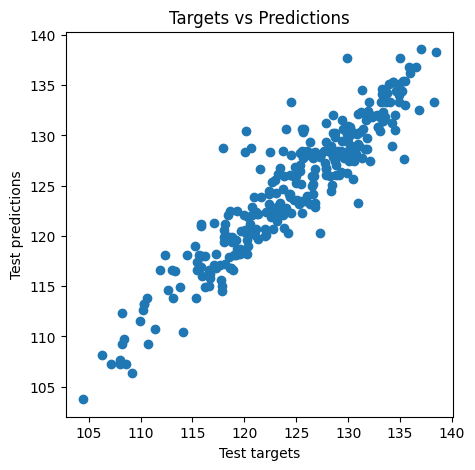

In [31]:
plt.figure(figsize=(5,5))

plt.scatter(Y_test, Y_pred)
plt.xlabel("Test targets")
plt.ylabel("Test predictions")
plt.title("Targets vs Predictions")